In [3]:
import os
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
path = "/content/drive/My Drive/notebook"
os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['testset-levelb.tsv',
 'testset-levelc.tsv',
 'labels-levelc.csv',
 'labels-levelb.csv',
 'olid-training-v1.0.tsv',
 'olid-annotation.txt',
 'labels-levela.csv',
 'output_RandomForest_learning.csv',
 'testset-levela.tsv',
 'output_Bayes_learning.csv',
 'CSI4900 TASK1.ipynb',
 'CSI4900_TASK2.ipynb',
 'output_SVM_learning_C.csv',
 'output_Bayes_learning_C.csv',
 'output_RandomForest_learning_C.csv',
 'CSI4900 TASK3.ipynb']

[9364, 2407, 395, 1074]


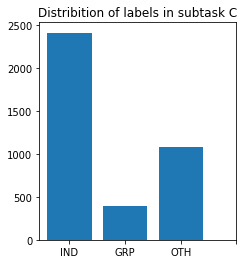

In [10]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from collections import Counter

import matplotlib.pyplot as plt

label_to_number_b = {'IND':0,'GRP':1,'OTH':2}
def clean_data(tweet):
    splitted_tweet = tweet.lower().split()
    clean_tweet = []
    previous_word = None
    user_count = 0
    for word in splitted_tweet:
        #if word not in spacy_stopwords:
        word = re.sub("[#@]","",word)
        word = re.sub("!"," !",word)
        word = re.sub("[?]"," ?",word)
        
        if(word == "user"):
          user_count += 1
          
        if(word == "user" and previous_word == "user"):
          pass
        else:
          clean_tweet.append(word)
          
        previous_word = word
          
    return " ".join(clean_tweet), user_count
#Deal with the dataset
def read(testfiletsv):
    plt.figure(figsize = (12,4))
    plt.subplot(132)
    a=pd.read_csv(testfiletsv, sep='\t',)
    cat_b = Counter(a["subtask_c"])
    x = cat_b.keys()
    x1 = []
    for i in x:
      if(isinstance(i,str)):
        x1.append(i)
    print(list(cat_b.values()))
    plt.bar(x1, [list(cat_b.values())[1],list(cat_b.values())[2],list(cat_b.values())[3]])
    plt.xticks(range(len(cat_b)), label_to_number_b)
    plt.title("Distribition of labels in subtask C");
    #since the distribution is not equal,we just choose 400 from both sample
    dfIND=a[a["subtask_c"] == "IND"].sample(n=390, random_state=3)
    dfGRP = a[a["subtask_c"] == "GRP"].sample(n=390, random_state=2)
    dfOTH = a[a["subtask_c"] == "OTH"].sample(n=390, random_state=1)
    #To prevent undersampling or Oversampling, we choose equal size of results
    dfPartial = dfIND.append(dfGRP)
    dfPartial = dfPartial.append(dfOTH)
    return dfPartial
a=read('olid-training-v1.0.tsv')

In [11]:
#First Method,Let us try Bays_learning method first
def learning(dfPartial):  
    train_reviews, test_reviews, train_tags, test_tags = train_test_split(dfPartial["tweet"],dfPartial["subtask_c"],test_size=0.1, random_state=3,             
                                                          stratify=dfPartial["subtask_c"])
    #we splite the training and testing datasets

    train_tags = train_tags.to_numpy()
    train_reviews = train_reviews.to_numpy()
    test_tags = test_tags.to_numpy()
    test_reviews = test_reviews.to_numpy()
    #convertion and normalization deal with data

    count_vect = CountVectorizer()
    train_counts = count_vect.fit_transform(train_reviews)
    return(train_counts, train_tags,count_vect)  

def Bayes_learning_result(train_counts, train_tags,count_vect,b):
    sentence=b['tweet']
    test_reviews_counts = count_vect.transform(sentence)
    clf = MultinomialNB().fit(train_counts, train_tags)  
    test_reviews_counts = count_vect.transform(sentence)
    # Predict the results
    prediction = clf.predict(test_reviews_counts)
    # Print the first ten predictions
    result=[]
    for idnum,docTest, categoryTest in zip(b['id'],b['tweet'], prediction):   
        #print('%r => %s\n' % (docTest, categoryTest))
        result.append([idnum,docTest, categoryTest])
    return(result)

[9364, 2407, 395, 1074]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


        id                                              tweet task3
0    15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...   OTH
1    60133  #NoPasaran: Unity demo to oppose the far-right...   OTH
2    83681           . . . What the fuck did he do this time?   IND
3    65507  @USER Do you get the feeling he is kissing @US...   IND
4    34263  #StopKavanaugh he is liar like the rest of the...   IND
..     ...                                                ...   ...
208  30778  #StopEtchecopar? Fuck you all 🖕🖕🖕🖕🖕 Que florez...   IND
209  22569  #Antifa are mentally unstable cowards, pretend...   GRP
210  48938  @USER @USER And Browning looked like dog shit ...   GRP
211  41438                All two of them taste like ass. URL   GRP
212  73439  #DespicableDems lie again about rifles. Dem Di...   GRP

[213 rows x 3 columns]


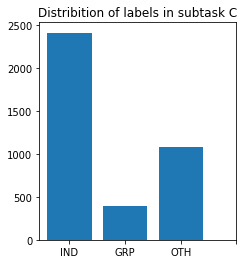

In [13]:
import re
a=read('olid-training-v1.0.tsv')
for i in a["tweet"]:
  a["tweet"][i]=clean_data(i)
train_counts, train_tags,count_vect=learning(a)
b=pd.read_csv('testset-levelc.tsv', delimiter='\t',)
result=Bayes_learning_result(train_counts, train_tags,count_vect,b)
Bayes_learning_final=pd.DataFrame(result, columns=['id','tweet','task3'])
print(Bayes_learning_final)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
def  Randomforest_learning(train_counts, train_tags,count_vect,b):
    sentence=b['tweet']
    test_reviews_counts = count_vect.transform(sentence)
    classifier = RandomForestClassifier(max_depth=800, min_samples_split=5)
    params = {'n_estimators': [n for n in range(50,200,50)], 'criterion':['gini','entropy'], }
    classifier = GridSearchCV(classifier, params, cv=3, n_jobs=4)
    classifier.fit(train_counts, train_tags)
    # Predict the results
    prediction = classifier.predict(test_reviews_counts)
    # Print the first ten predictions
    result=[]
    for idnum,docTest, categoryTest in zip(b['id'],b['tweet'], prediction):   
        #print('%r => %s\n' % (docTest, categoryTest))
        result.append([idnum,docTest, categoryTest])
    return(result)

In [15]:
train_counts, train_tags,count_vect=learning(a)
b=pd.read_csv('testset-levelc.tsv', delimiter='\t',)
result=Randomforest_learning(train_counts, train_tags,count_vect,b)
Randomforest_learning_final=pd.DataFrame(result, columns=['id','tweet','task3'])
print(Randomforest_learning_final)

        id                                              tweet task3
0    15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...   OTH
1    60133  #NoPasaran: Unity demo to oppose the far-right...   OTH
2    83681           . . . What the fuck did he do this time?   IND
3    65507  @USER Do you get the feeling he is kissing @US...   IND
4    34263  #StopKavanaugh he is liar like the rest of the...   IND
..     ...                                                ...   ...
208  30778  #StopEtchecopar? Fuck you all 🖕🖕🖕🖕🖕 Que florez...   IND
209  22569  #Antifa are mentally unstable cowards, pretend...   OTH
210  48938  @USER @USER And Browning looked like dog shit ...   IND
211  41438                All two of them taste like ass. URL   GRP
212  73439  #DespicableDems lie again about rifles. Dem Di...   OTH

[213 rows x 3 columns]


In [17]:
from sklearn.svm import SVC
def  SVM(train_counts, train_tags,count_vect,b):
    sentence=b['tweet']
    test_reviews_counts = count_vect.transform(sentence)
    classifier = SVC()
    classifier = GridSearchCV(classifier, {'C':[0.001, 0.01, 0.1, 1, 10]}, cv=3, n_jobs=4)
    classifier.fit(train_counts, train_tags)
    # Predict the results
    prediction = classifier.predict(test_reviews_counts)
    # Print the first ten predictions
    result=[]
    for idnum,docTest, categoryTest in zip(b['id'],b['tweet'], prediction):   
        #print('%r => %s\n' % (docTest, categoryTest))
        result.append([idnum,docTest, categoryTest])
    return(result)

In [18]:
train_counts, train_tags,count_vect=learning(a)
b=pd.read_csv('testset-levelc.tsv', delimiter='\t',)
result=SVM(train_counts, train_tags,count_vect,b)
SVM_final=pd.DataFrame(result, columns=['id','tweet','task3'])
print(SVM_final)

        id                                              tweet task3
0    15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...   OTH
1    60133  #NoPasaran: Unity demo to oppose the far-right...   OTH
2    83681           . . . What the fuck did he do this time?   IND
3    65507  @USER Do you get the feeling he is kissing @US...   IND
4    34263  #StopKavanaugh he is liar like the rest of the...   IND
..     ...                                                ...   ...
208  30778  #StopEtchecopar? Fuck you all 🖕🖕🖕🖕🖕 Que florez...   IND
209  22569  #Antifa are mentally unstable cowards, pretend...   GRP
210  48938  @USER @USER And Browning looked like dog shit ...   IND
211  41438                All two of them taste like ass. URL   IND
212  73439  #DespicableDems lie again about rifles. Dem Di...   OTH

[213 rows x 3 columns]


In [20]:
from sklearn import metrics
from sklearn.metrics import classification_report
def result_compare():
  b=pd.read_csv('labels-levelc.csv',names=["id","task3"])
  print("Bays_Learning")
  print(classification_report(b["task3"], Bayes_learning_final["task3"],target_names=["IND","GRP","OTH"]))
  print("########################################################################################")
  Bayes_learning_final.to_csv("./output_Bayes_learning_C.csv")  
  print("RandomForest")
  print(classification_report(b["task3"], Randomforest_learning_final["task3"],target_names=["IND","GRP","OTH"]))
  print("########################################################################################")
  Randomforest_learning_final.to_csv("./output_RandomForest_learning_C.csv") 
  print("SVM")
  print(classification_report(b["task3"], SVM_final["task3"],target_names=["IND","GRP","OTH"]))
  SVM_final.to_csv("./output_SVM_learning_C.csv") 
result_compare()

Bays_Learning
              precision    recall  f1-score   support

         IND       0.56      0.64      0.60        78
         GRP       0.77      0.61      0.68       100
         OTH       0.27      0.34      0.30        35

    accuracy                           0.58       213
   macro avg       0.53      0.53      0.53       213
weighted avg       0.61      0.58      0.59       213

########################################################################################
RandomForest
              precision    recall  f1-score   support

         IND       0.65      0.60      0.63        78
         GRP       0.77      0.67      0.72       100
         OTH       0.26      0.40      0.31        35

    accuracy                           0.60       213
   macro avg       0.56      0.56      0.55       213
weighted avg       0.64      0.60      0.62       213

########################################################################################
SVM
              precision    re